In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import mse

plt.style.use('default')
plt.rcParams["figure.figsize"] = (12*1.618,12)

from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def my_acf_pacf_plot(series, nlags=40, ci_alpha=0.05, skip_0=False, size=(12, 10),title_add=None):
    
    nobs = series.shape[0]
    lim = min(nlags, min(int(np.ceil(12 * np.log10(nobs))), nobs - 1) )
    lags = np.arange(lim+1)
    
    
    acf_x, acf_confint = acf(series, nlags=len(lags)-1, alpha=ci_alpha)
    pacf_x, pacf_confint = pacf(series, nlags=len(lags)-1, alpha=ci_alpha, method='ywm')
    
    atitle = 'Autocorrelation'
    ptitle = 'Partial Autocorrelation'
    if title_add is not None:
        atitle = atitle + ' of ' +title_add
        ptitle = ptitle + ' of ' +title_add
    
    if skip_0:
        lags = lags[1:]
        acf_x = acf_x[1:]
        acf_confint = acf_confint[1:,]
        atitle = atitle+ '\n(lag 0 not shown)'
        
        pacf_x = pacf_x[1:]
        pacf_confint = pacf_confint[1:,]
        ptitle = ptitle+ '\n(lag 0 not shown)'
        
    fig = plt.figure(figsize=size)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa._plot_corr(ax=ax1, title=atitle, acf_x=acf_x, confint=None, lags=lags,
                          irregular=False, use_vlines=True, vlines_kwargs={'color':'k'},
                          color='k')
    acf_lim = max(np.max(np.abs(acf_x)), np.max(np.abs(acf_confint)) )
    ax1.set_ylim(-(acf_lim*1.1), acf_lim*1.1)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa._plot_corr(ax=ax2, title=ptitle, acf_x=pacf_x, confint=None, lags=lags,
                          irregular=False, use_vlines=True, vlines_kwargs={'color':'k'},
                          color='k')
    pacf_lim = max(np.max(np.abs(pacf_x)), np.max(np.abs(pacf_confint)) )
    ax2.set_ylim(-(pacf_lim*1.1), pacf_lim*1.1)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_xlabel('Lag')
    #ax2.set_ylabel('')

    lags = lags.astype(float)
    lags[0] -= 0.5
    lags[-1] += 0.5
    ax1.plot(lags, acf_confint[:, 0] - acf_x, linestyle='dashed', color='k')
    ax1.plot(lags, acf_confint[:, 1] - acf_x, linestyle='dashed', color='k')
    ax1.fill_between(lags, acf_confint[:, 0] - acf_x, acf_confint[:, 1] - acf_x, 
                     alpha=0.2, color='k')

    ax2.plot(lags, pacf_confint[:, 0] - pacf_x, linestyle='dashed', color='k')
    ax2.plot(lags, pacf_confint[:, 1] - pacf_x, linestyle='dashed', color='k')    
    ax2.fill_between(lags, pacf_confint[:, 0] - pacf_x, pacf_confint[:, 1] - pacf_x, 
                     alpha=0.2, color='k')
    
    return fig

In [2]:
data = pd.read_excel('I4_1.xlsx',skiprows=18,index_col=0)
data.head()

,VALUE
DATE,
1968-01-01,46030000
1968-02-01,45790000
1968-03-01,47510000
1968-04-01,48840000
1968-05-01,49540000


In [3]:
#monthly dummies
data["MONTH"] = data.index.month
data = pd.get_dummies(data,columns=['MONTH'],drop_first=True)

#12 and 24th month dummy
#data["EOY"] = np.where(data["MONTH_12"]==1, 1, 0)

#log?
data['logvalue'] = np.log(data['VALUE'])

#differenced?
data['diff'] = data['VALUE'].diff()

#logdiff?
data['logdiff'] = np.log(data['VALUE']).diff()

data = data.dropna()
data.head()

,VALUE,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,logvalue,diff,logdiff
DATE,,,,,,,,,,,,,,,
1968-02-01,45790000,1,0,0,0,0,0,0,0,0,0,0,17.639576,-240000.0,-0.005228
1968-03-01,47510000,0,1,0,0,0,0,0,0,0,0,0,17.676451,1720000.0,0.036874
1968-04-01,48840000,0,0,1,0,0,0,0,0,0,0,0,17.704060,1330000.0,0.027609
1968-05-01,49540000,0,0,0,1,0,0,0,0,0,0,0,17.718291,700000.0,0.014231
1968-06-01,49570000,0,0,0,0,1,0,0,0,0,0,0,17.718896,30000.0,0.000605


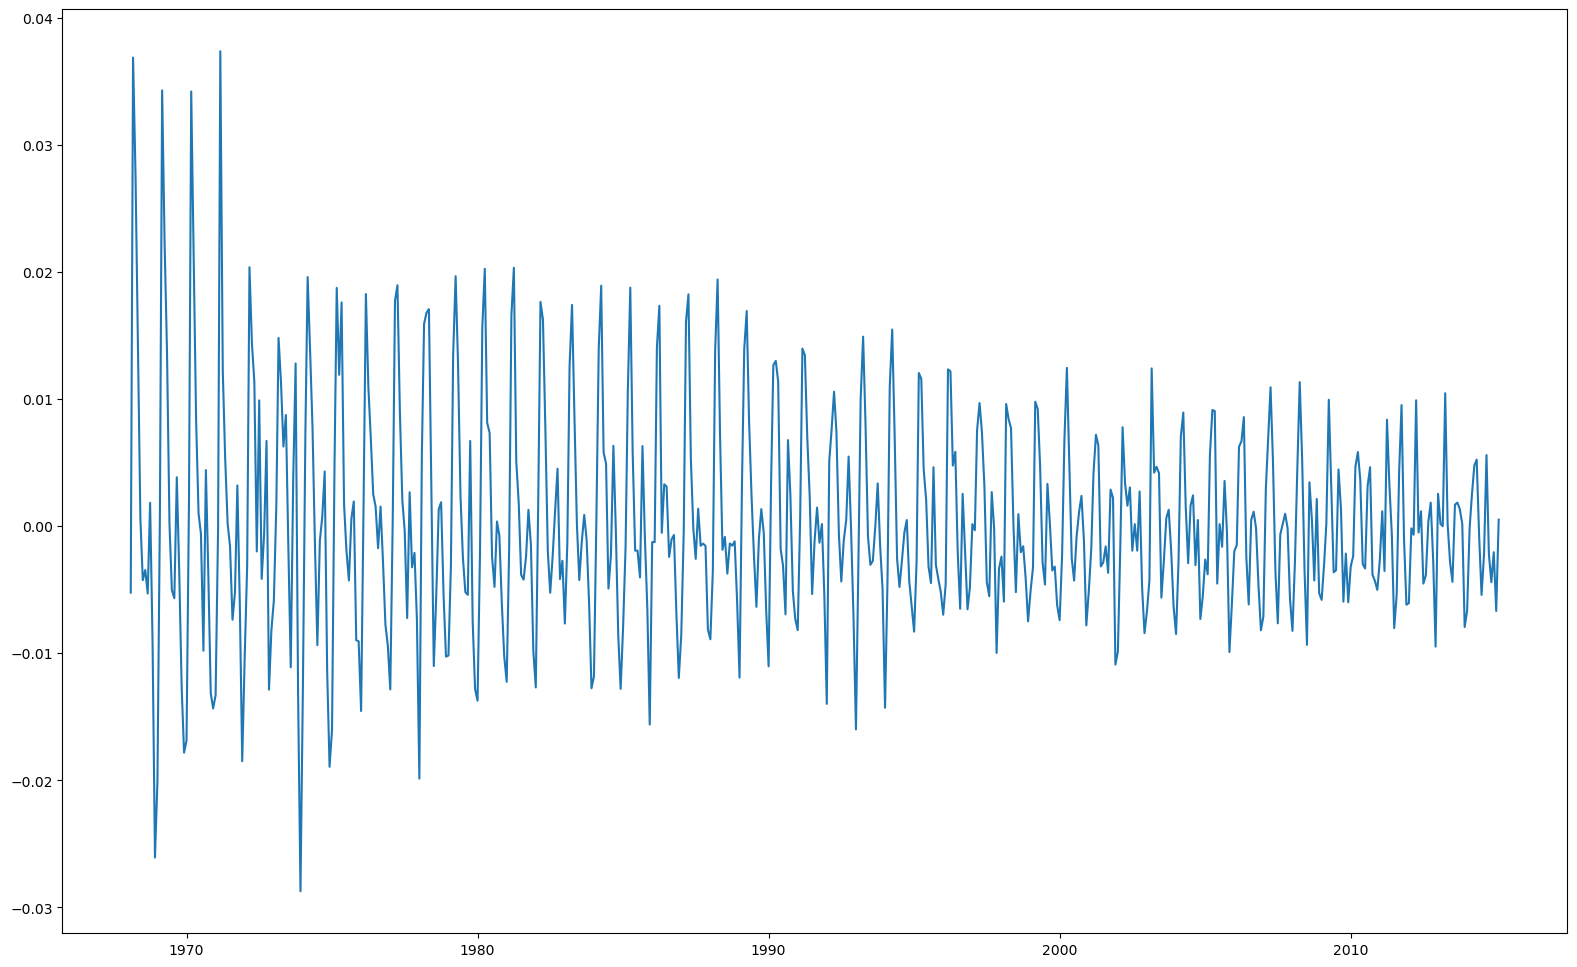

In [4]:
plt.plot(data['logdiff'])

In [5]:
size = int(len(data) * 0.80)
train, test = data[0:size], data[size:len(data)]

month_dummies = train.copy().drop(['VALUE','logvalue','diff','logdiff'],axis=1).dropna()
test_month_dummies = test.copy().drop(['VALUE','logvalue','diff','logdiff'],axis=1).dropna()

In [6]:
test_month_dummies.head()

,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
DATE,,,,,,,,,,,
2005-10-01,0,0,0,0,0,0,0,0,1,0,0
2005-11-01,0,0,0,0,0,0,0,0,0,1,0
2005-12-01,0,0,0,0,0,0,0,0,0,0,1
2006-01-01,0,0,0,0,0,0,0,0,0,0,0
2006-02-01,1,0,0,0,0,0,0,0,0,0,0


In [7]:
model1 = ARIMA(train['logdiff'], order=(2,0,1),exog=month_dummies,freq='MS')
model1_fit = model1.fit()
print(model1_fit.summary())

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                logdiff   No. Observations:                  452
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1824.998
Date:                Mon, 20 Mar 2023   AIC                          -3617.996
Time:                        11:52:11   BIC                          -3552.177
Sample:                    02-01-1968   HQIC                         -3592.059
                         - 09-01-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0102      0.001    -14.303      0.000      -0.012      -0.009
MONTH_2        0.0096      0.001      8.971      0.000       0.007       0.012
MONTH_3        0.0253      0.001     25.459      0.0

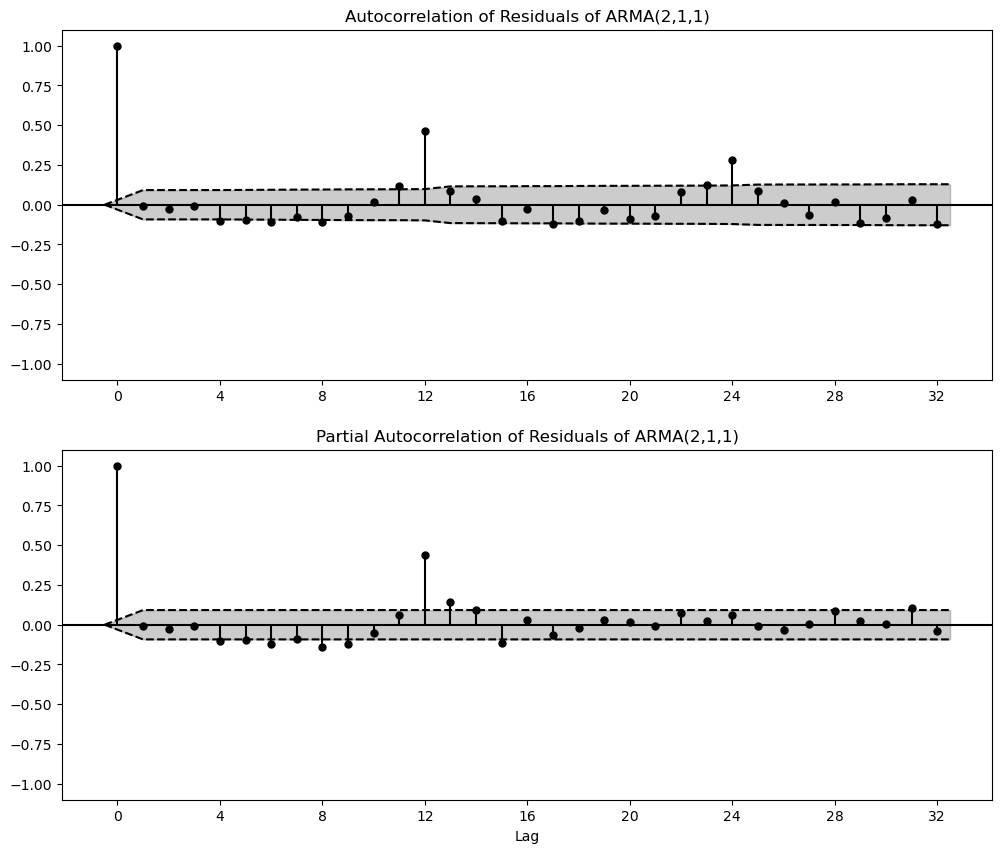

In [8]:
model1plots = my_acf_pacf_plot(model1_fit.resid,title_add='Residuals of ARMA(2,1,1)')

In [9]:
## ARMA(1,1,0) = -3598.584; -3540.992
## ARMA(1,1,1) = -3603.006; -3541.300
## ARMA(2,1,1) = -3617.996; -3552.177
## ARMA(2,1,2) = -3586.792; -3516.859
## ARMA(3,1,2) = -3586.725 -3512.679

In [10]:
pred = model1_fit.forecast(steps=len(test),exog=test_month_dummies)
#pred_df = pd.DataFrame(pred, index=test.index)

test_float = list(round(test['logdiff'],5))
pred_float = list(round(pred ,5))

mse1 = mse(test_float, pred_float)
mse1
# rmse = sqrt(mse)
# rmse
#type(pred_float[1])

3.202514778761062e-05

In [11]:
r_mse = np.sqrt(mse1)
r_mse

0.005659076584356376

Text(2014-06-01 00:00:00, 0.0075, 'Forecast')

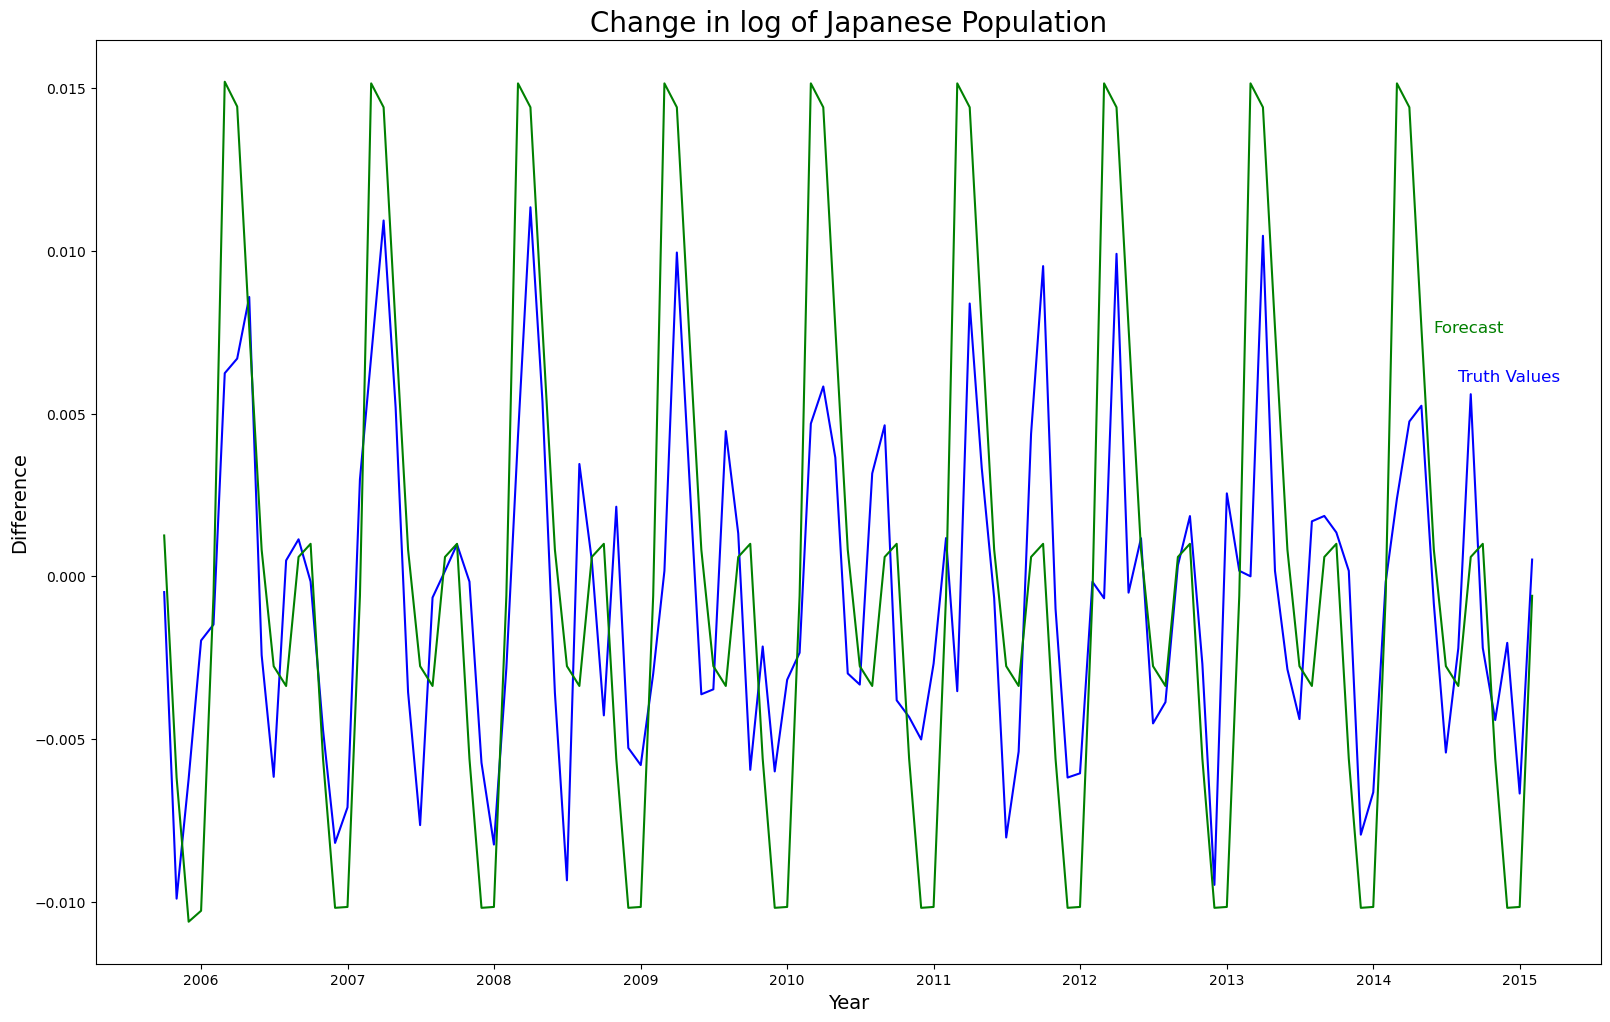

In [12]:
#Plotting

#plt.plot(train['logdiff'], 'k') #Not plotting this "zooms into" the forecasting area
plt.plot(test['logdiff'],'b')
plt.plot(pred,'g')

plt.title("Change in log of Japanese Population",fontsize=20)
plt.xlabel("Year",fontsize=14)
plt.ylabel("Difference",fontsize=14)
plt.grid(False)

plt.text(test['logdiff'].index[106],0.006,'Truth Values',color='b',fontsize=12)
plt.text(test['logdiff'].index[104],0.0075,'Forecast',color='g',fontsize=12)

In [13]:
###UNUSED###

model2 = ARIMA(train['logdiff'], order=([12],0,2),exog=month_dummies,freq='MS')
model2_fit = model2.fit()
print(model2_fit.summary())

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                logdiff   No. Observations:                  452
Model:              ARIMA([12], 0, 2)   Log Likelihood                1902.528
Date:                Mon, 20 Mar 2023   AIC                          -3773.057
Time:                        11:52:13   BIC                          -3707.238
Sample:                    02-01-1968   HQIC                         -3747.120
                         - 09-01-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0103      0.001     -7.366      0.000      -0.013      -0.008
MONTH_2        0.0094      0.002      4.268      0.000       0.005       0.014
MONTH_3        0.0258      0.002     13.383      0.0

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
## AIC; BIC
## order=([2,12],0,1) : -3750.150; -3684.331
## order=([2,12],0,2) : -3772.794; -3702.861
## order=([12],0,1) : -3740.536; -3678.831
## order=([12],0,2) : -3773.057; -3747.120
## order=([12],0,[12]): -3747.741; -3723.426

Text(2014-06-01 00:00:00, 0.0075, 'Forecast')

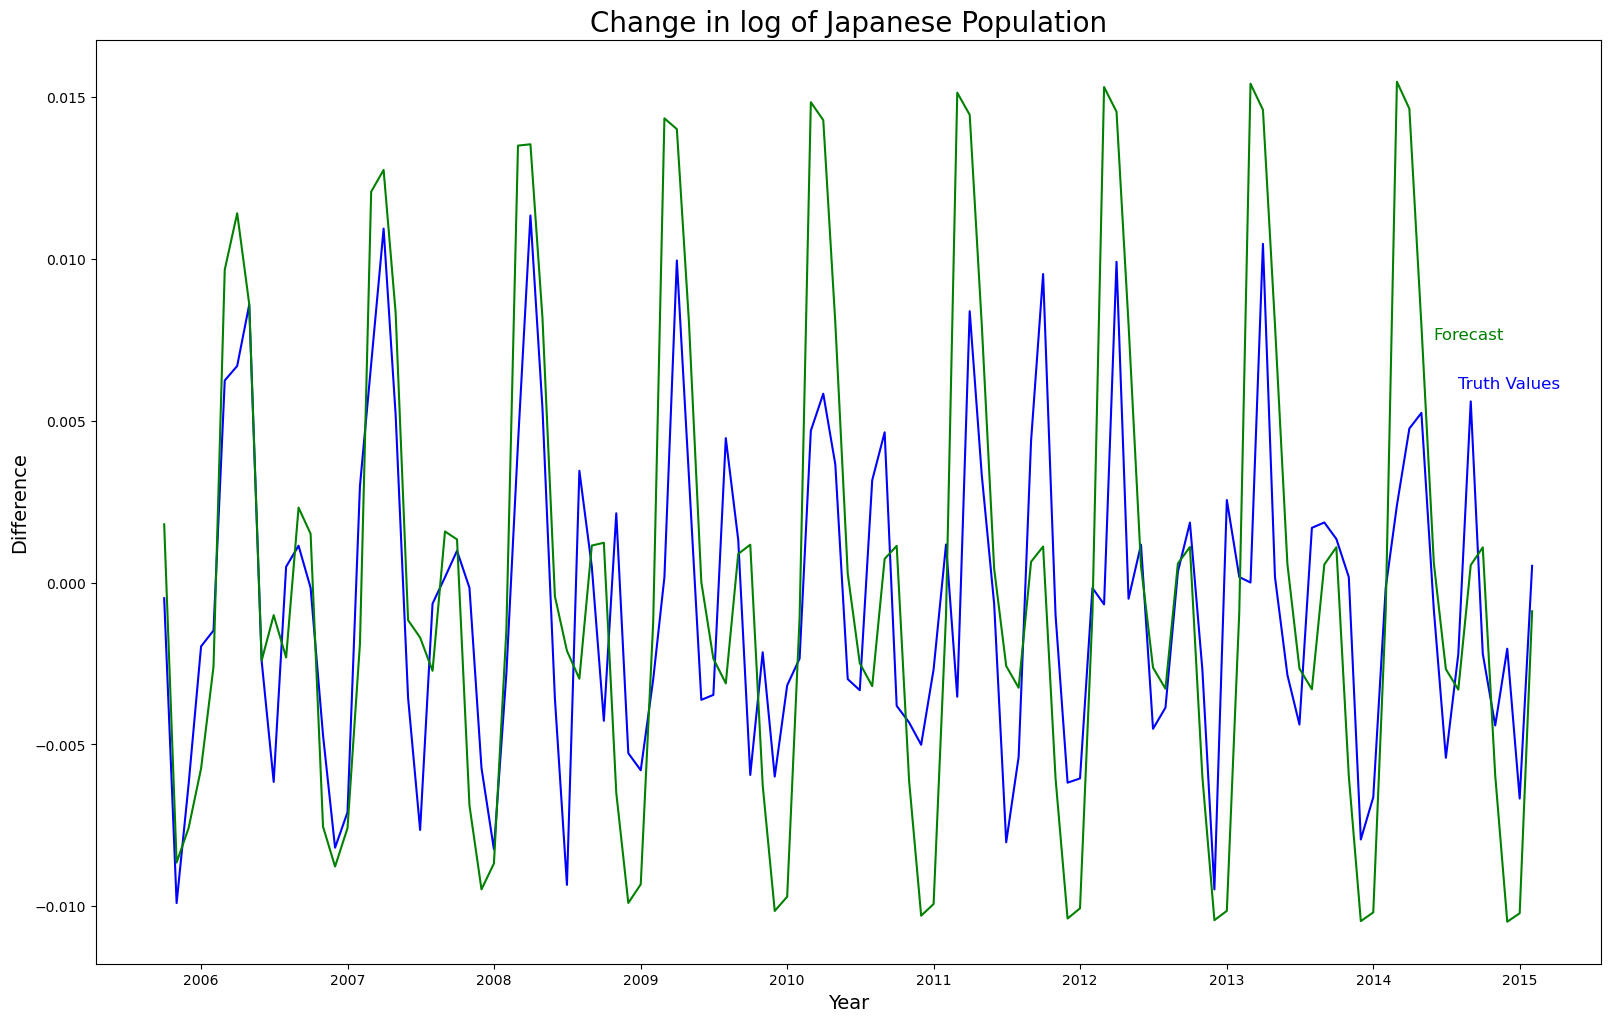

In [15]:
pred2 = model2_fit.forecast(steps=len(test),exog=test_month_dummies)
#pred2_df = pd.DataFrame(pred2, index=test.index)

#Plotting

#plt.plot(train['logdiff'], 'k') #Not plotting this "zooms into" the forecasting area
plt.plot(test['logdiff'],'b')
plt.plot(pred2,'g')

plt.title("Change in log of Japanese Population",fontsize=20)
plt.xlabel("Year",fontsize=14)
plt.ylabel("Difference",fontsize=14)
plt.grid(False)

plt.text(test['logdiff'].index[106],0.006,'Truth Values',color='b',fontsize=12)
plt.text(test['logdiff'].index[104],0.0075,'Forecast',color='g',fontsize=12)

## Back to Deterministic... Thanks Dr. Schindler

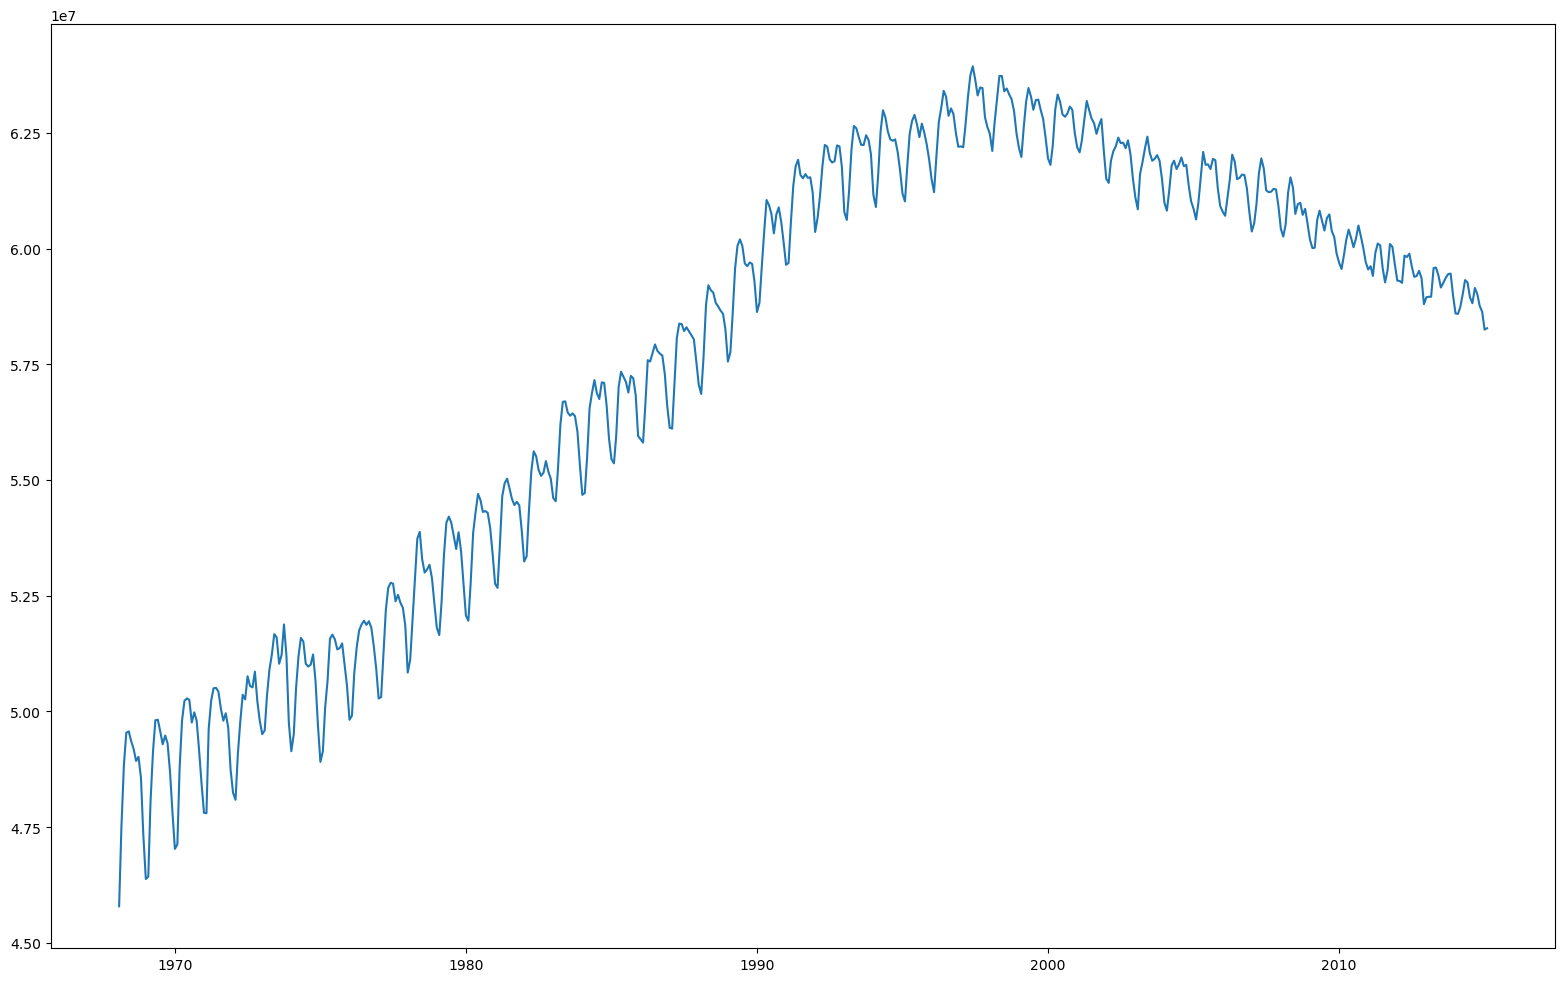

In [16]:
plt.plot(data['VALUE'])

In [17]:
max(data['VALUE'])

63940000

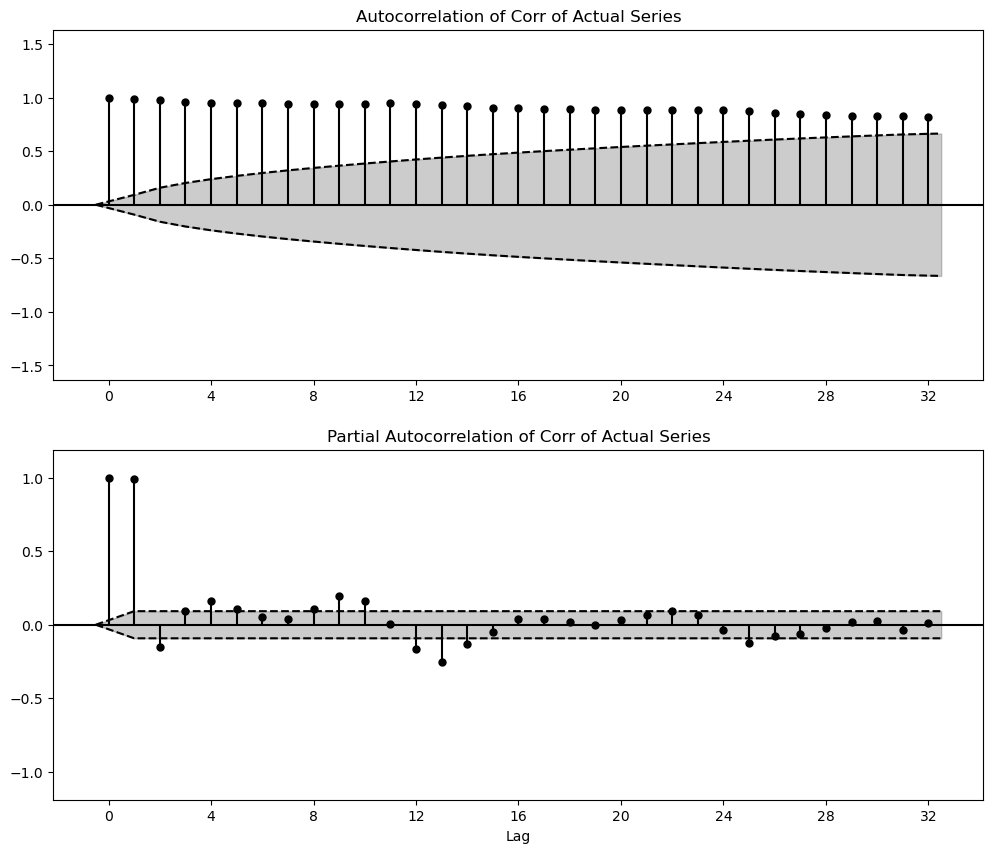

In [18]:
model3_pre_corr = my_acf_pacf_plot(train['VALUE'],title_add='Corr of Actual Series')

In [19]:
time_dum = month_dummies.copy()
test_time_dum = test_month_dummies.copy()

In [20]:
time_dum['lostdecade_1990'] = np.where(train.index > '1990-01-01 00:00:00', 1, 0)
time_dum['value_t'] = (np.arange(len(time_dum))+1) * train['VALUE']
time_dum['value_t2'] = time_dum['value_t']**2
#time_dum = time_dum.drop(['value_t'],axis=1)

test_time_dum['lostdecade_1990'] = np.where(test.index > '1990-01-01 00:00:00', 1, 0)
test_time_dum['value_t'] = (np.arange(len(test_time_dum))+1) * test['VALUE']
test_time_dum['value_t2'] = test_time_dum['value_t']**2
#test_time_dum = test_time_dum.drop(['value_t'],axis=1)

In [21]:
## ARMA(1,0,0) = 12502.820; 12560.411 
## ARMA(1,0,1) = 12501.401; 12563.106
## ARMA(2,0,0) =  12502.495; 12564.201
## ARMA(2,0,1) = 12501.986; 12567.805
## ARMA(2,0,2) = 12489.359; 12559.292 *best AIC *best BIC 
## ARMA(3,0,0) = 12492.458 12558.276
## ARMA(3,0,1) = 12489.705 12559.638 
## ARMA(3,0,2) = 12491.199 12565.246

model3 = ARIMA(train['VALUE'], order=(2,0,2),exog=month_dummies,freq='MS')
model3_fit = model3.fit()
print(model3_fit.summary())

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                  452
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6227.680
Date:                Mon, 20 Mar 2023   AIC                          12489.359
Time:                        11:52:14   BIC                          12559.292
Sample:                    02-01-1968   HQIC                         12516.917
                         - 09-01-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.589e+07   4.69e-10   1.19e+17      0.000    5.59e+07    5.59e+07
MONTH_2    -3.003e+05    8.9e-07  -3.37e+11      0.000      -3e+05      -3e+05
MONTH_3      5.15e+05   2.08e-07   2.47e+12      0.0

In [22]:
pred3 = model3_fit.forecast(steps=len(test),exog=test_month_dummies)

test_float3 = list(round(test['VALUE'],5))
pred_float3 = list(round(pred3 ,5))

mse3 = mse(test_float3, pred_float3)
rmse3 = np.sqrt(mse3)
rmse3

1540983.8132953327

Text(2014-10-01 00:00:00, 59900000, 'Forecast')

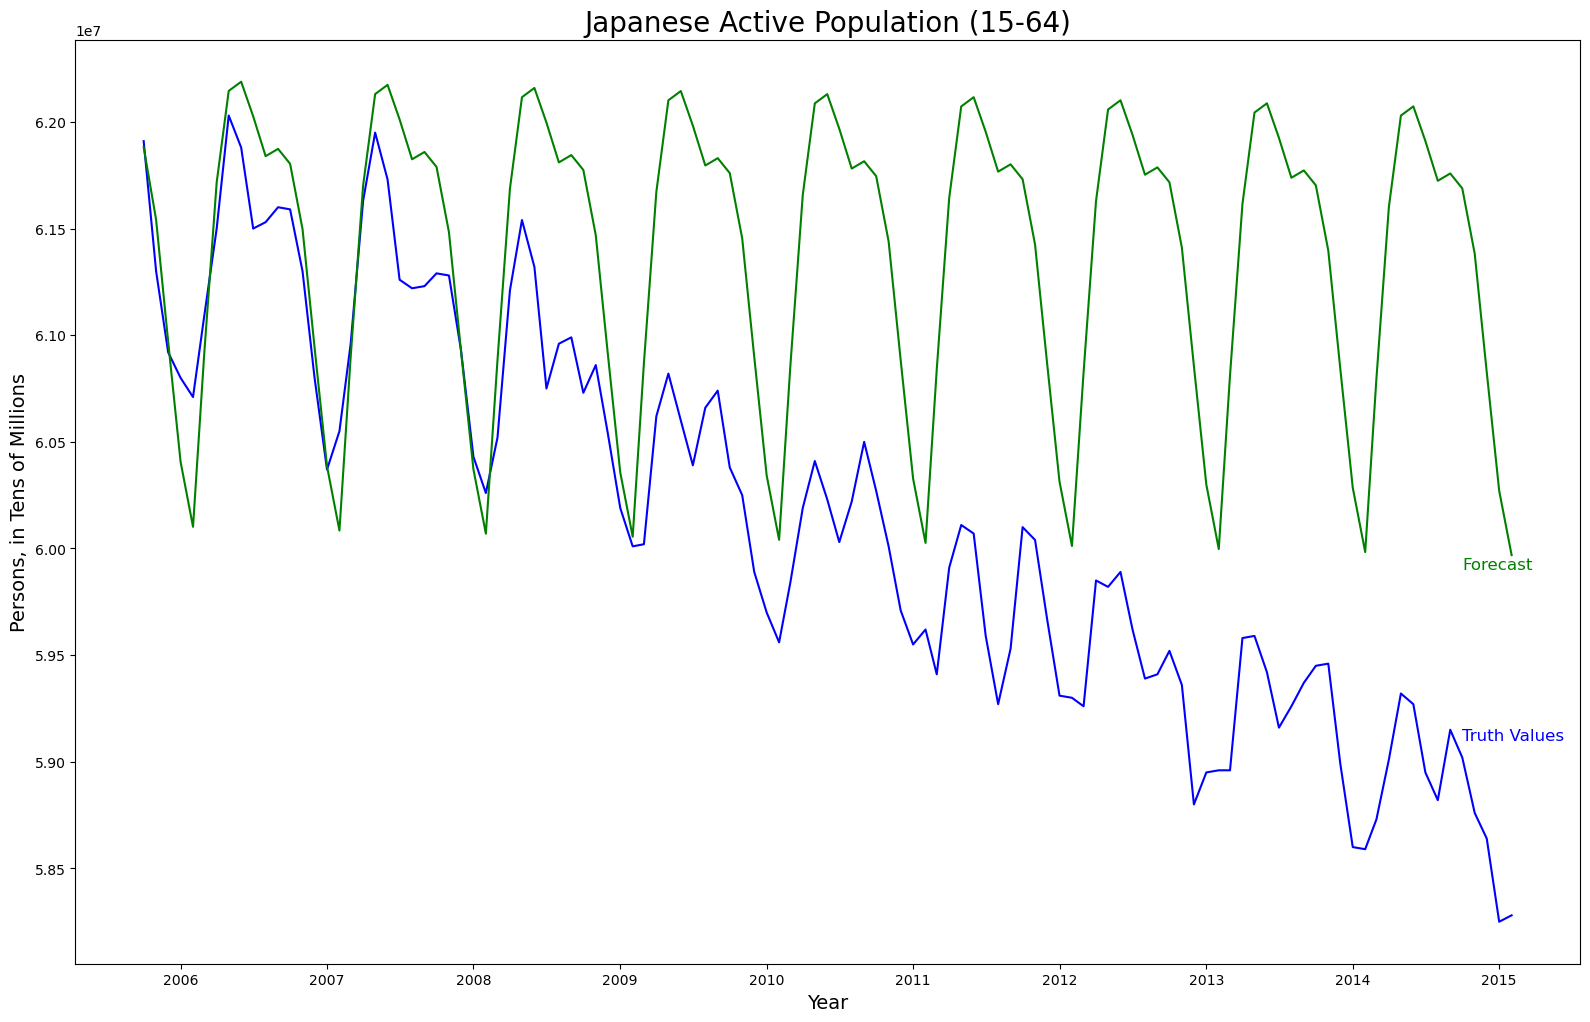

In [23]:
#Plotting model 3

#plt.plot(train['logdiff'], 'k') #Not plotting this "zooms into" the forecasting area
# plt.plot([x/10000000 for x in test['VALUE']],'b')
# plt.plot([y/10000000 for y in pred3],'g')

plt.plot(test['VALUE'],'b')
plt.plot(pred3,'g')

# 10 000 000

plt.title("Japanese Active Population (15-64)",fontsize=20)
plt.xlabel("Year",fontsize=14)
plt.ylabel("Persons, in Tens of Millions",fontsize=14)
plt.grid(False)

plt.text(test['VALUE'].index[108],59100000,'Truth Values',color='b',fontsize=12)
plt.text(test['VALUE'].index[108],59900000,'Forecast',color='g',fontsize=12)
# plt.text(108,5.99,'Forecast',color='g',fontsize=12)
# plt.text(100,5.94,'Truth Values',color='b',fontsize=12)

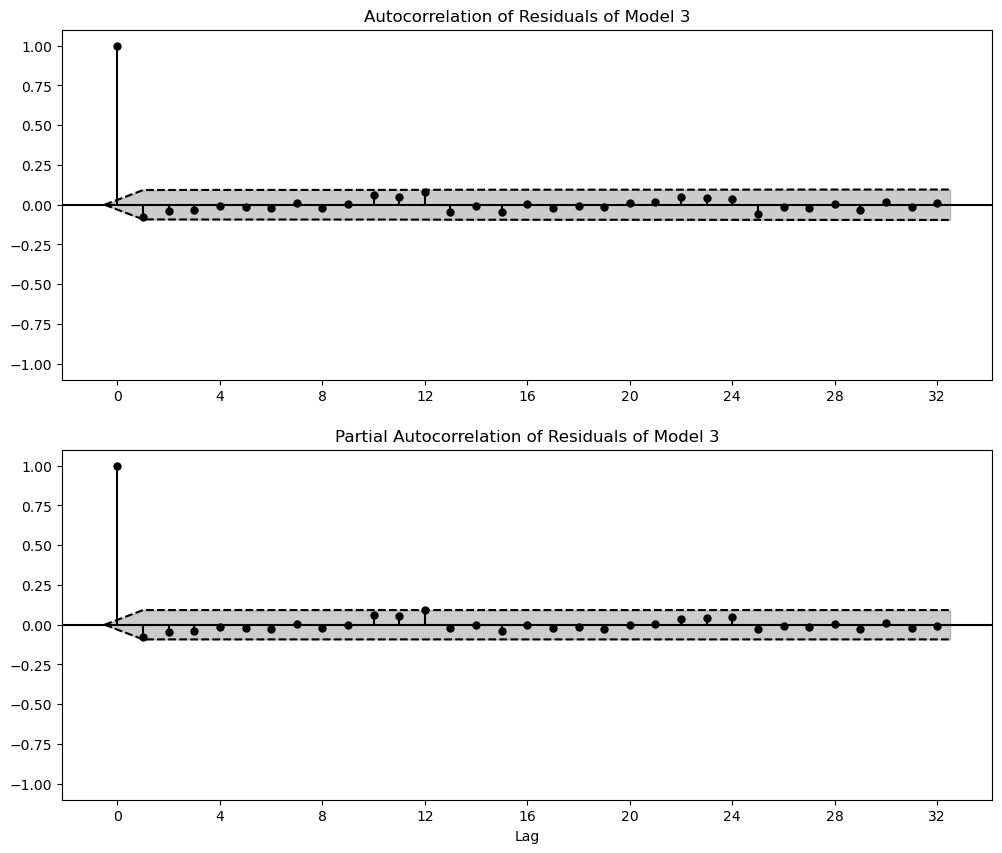

In [24]:
model3plots = my_acf_pacf_plot(model3_fit.resid,title_add='Residuals of Model 3')

In [25]:
## ARMA(1,0,0) = 14211.393; 14281.326
## ARMA(1,0,1) = 14155.999; 14230.045 *best AIC *best BIC
## ARMA(2,0,0) =  14163.244; 14237.291
## ARMA(2,0,1) = 14158.748; 14236.908 
## ARMA(2,0,2) = 14163.119; 14245.393 
## ARMA(3,0,0) = 14162.583 14240.743
## ARMA(3,0,1) = 14166.170 14248.444 
## ARMA(3,0,2) = 14546.267 14632.654

model4 = ARIMA(train['VALUE'], order=(1,0,1),exog=time_dum.drop(['value_t','value_t2'],axis=1),freq='MS')
model4_fit = model4.fit()
print(model4_fit.summary())

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                  452
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6532.676
Date:                Mon, 20 Mar 2023   AIC                          13097.353
Time:                        11:52:15   BIC                          13163.172
Sample:                    02-01-1968   HQIC                         13123.290
                         - 09-01-2005                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.232e+07   2045.273   2.56e+04      0.000    5.23e+07    5.23e+07
MONTH_2          -4.38e+05   4.79e+04     -9.154      0.000   -5.32e+05   -3.44e+05
MONTH_3          3.772e+05   5.2

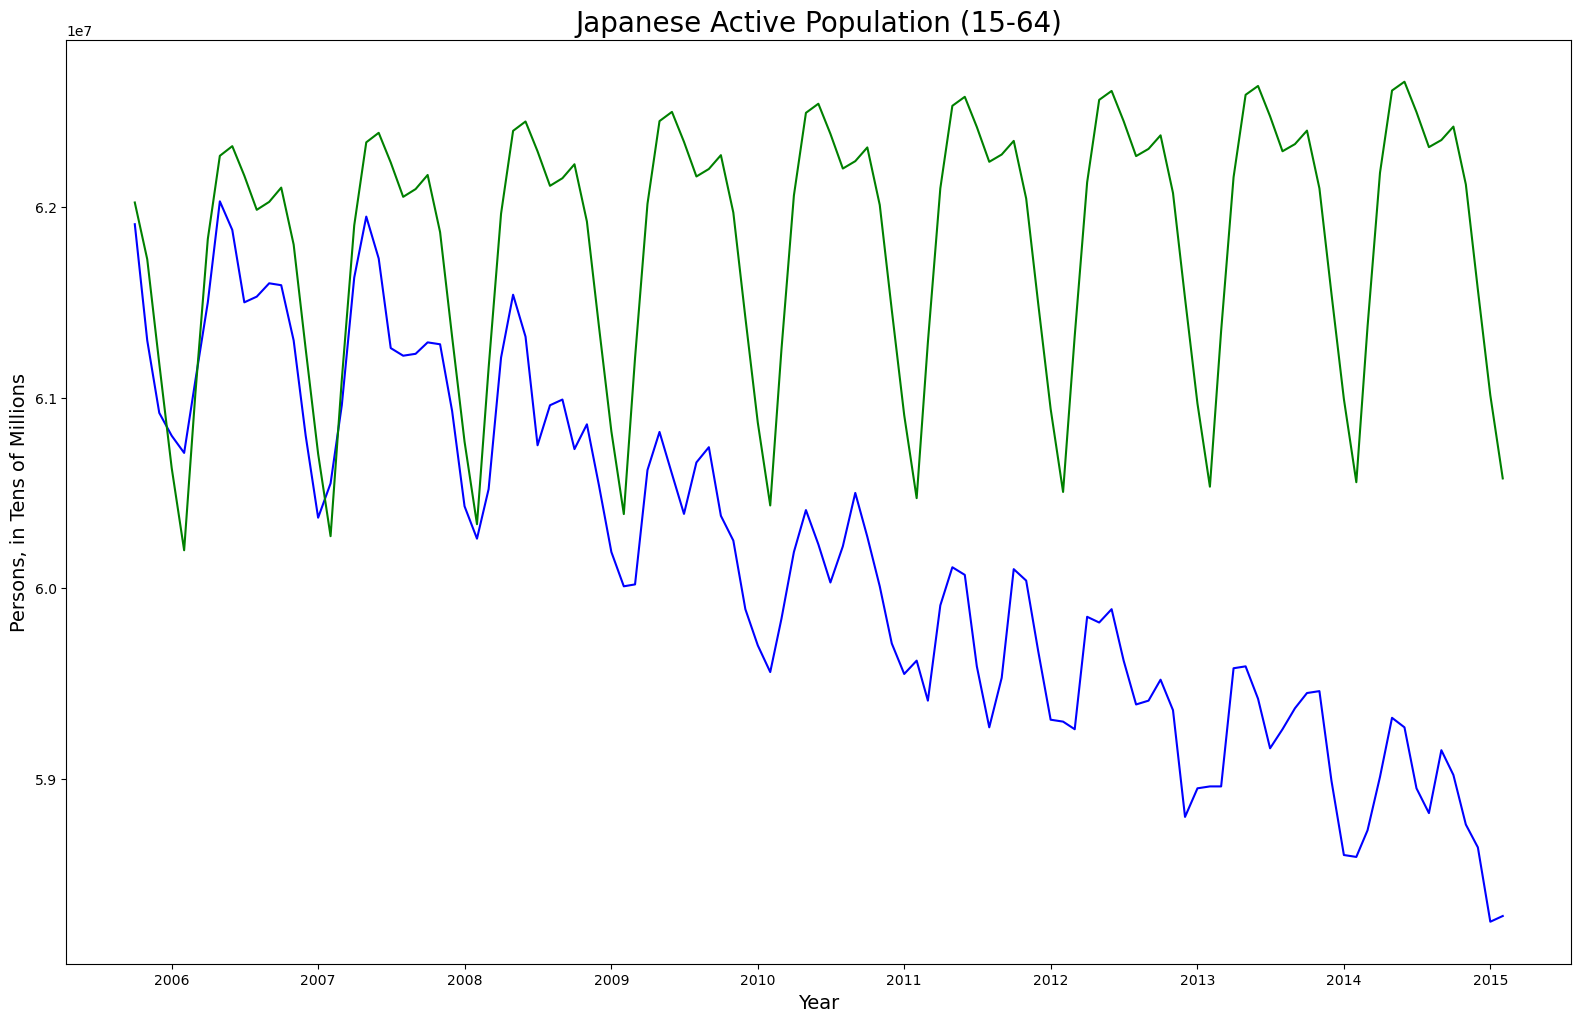

In [26]:
pred4 = model4_fit.forecast(steps=len(test),exog=test_time_dum.drop(['value_t','value_t2'],axis=1))

test_float4 = list(round(test['VALUE'],5))
pred_float4 = list(round(pred4 ,5))

mse4 = mse(test_float4, pred_float4)
rmse4 = np.sqrt(mse4)


#Plotting model 4
#plt.plot(train['VALUE'],'k')
plt.plot(test['VALUE'],'b')
plt.plot(pred4,'g')

# 10 000 000

plt.title("Japanese Active Population (15-64)",fontsize=20)
plt.xlabel("Year",fontsize=14)
plt.ylabel("Persons, in Tens of Millions",fontsize=14)
plt.grid(False)

#plt.text(test['VALUE'].index[108],6,'Truth Values',color='b',fontsize=12)
# plt.text(test['VALUE'].index[108],6.20,'Forecast',color='g',fontsize=12)
# plt.text(108,5.99,'Forecast',color='g',fontsize=12)
# plt.text(100,5.94,'Truth Values',color='b',fontsize=12)

In [33]:
rmse4

1975818.3917041493

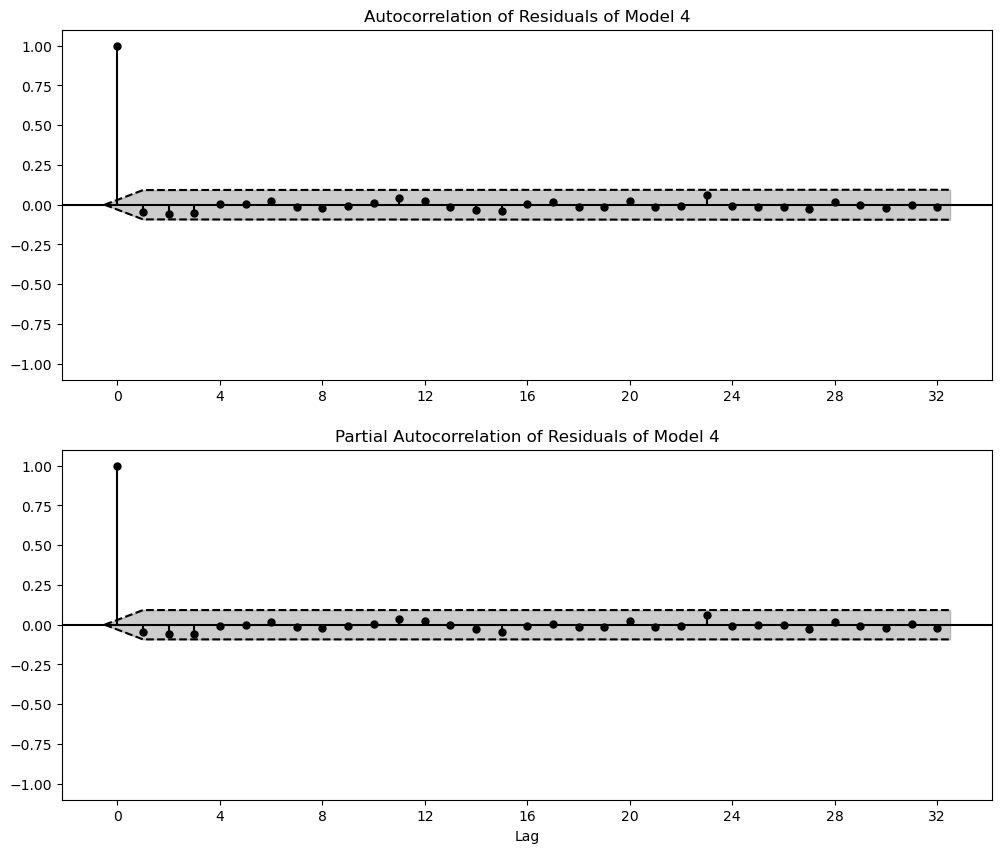

In [27]:
model4lots = my_acf_pacf_plot(model4_fit.resid,title_add='Residuals of Model 4')

In [28]:
model5 = ARIMA(train['VALUE'], order=(1,0,1),exog=time_dum.drop(['value_t'],axis=1),freq='MS')
model5_fit = model5.fit()
print(model5_fit.summary())

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                  452
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -470065.061
Date:                Mon, 20 Mar 2023   AIC                         940164.122
Time:                        11:52:15   BIC                         940234.055
Sample:                    02-01-1968   HQIC                        940191.680
                         - 09-01-2005                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.911e-30         -0       -inf      0.000    1.91e-30    1.91e-30
MONTH_2                  0         -0        nan        nan           0           0
MONTH_3          1.607e-31   5.7

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


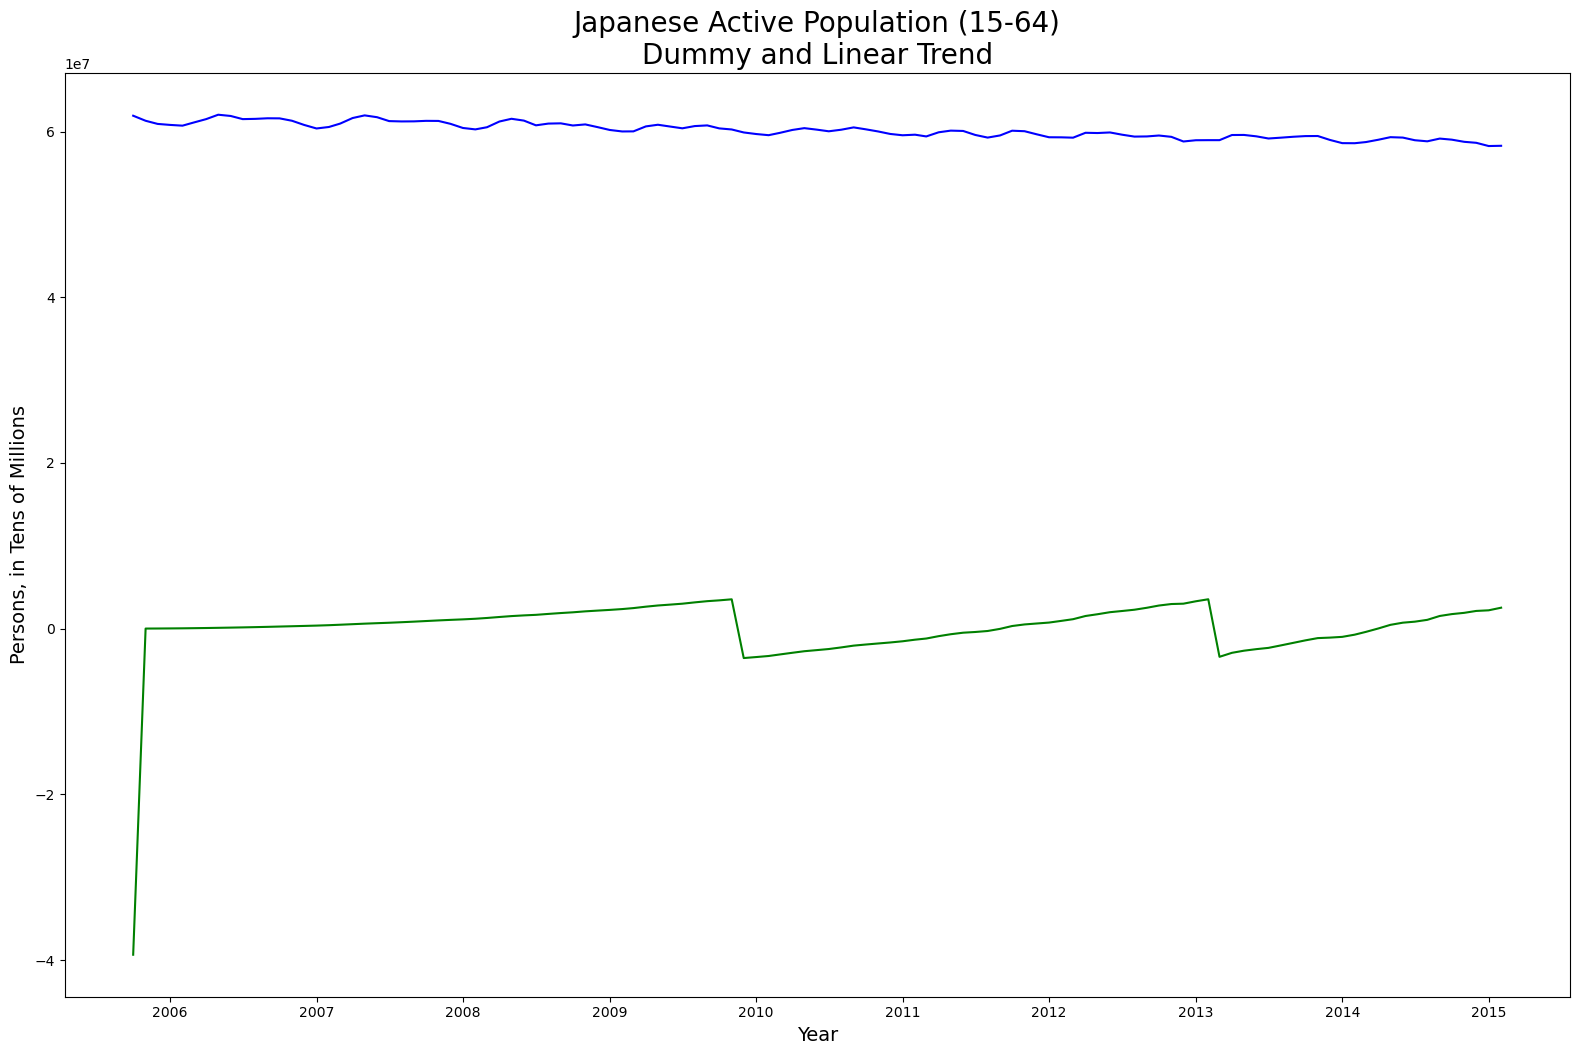

In [29]:
pred5 = model5_fit.forecast(steps=len(test),exog=test_time_dum.drop(['value_t'],axis=1))

test_float5 = list(round(test['VALUE'],5))
pred_float5 = list(round(pred5 ,5))

mse5 = mse(test_float5, pred_float5)

#Plotting model 5
#plt.plot(train['VALUE'],'k')
plt.plot(test['VALUE'],'b')
plt.plot(pred5,'g')

# 10 000 000

plt.title("Japanese Active Population (15-64)\nDummy and Linear Trend",fontsize=20)
plt.xlabel("Year",fontsize=14)
plt.ylabel("Persons, in Tens of Millions",fontsize=14)
plt.grid(False)

In [31]:
rmse5 = np.sqrt(mse5)
rmse5

60243903.234917976